Урок 7. Интерпретация прогнозов модели (SHAP): объясняем поведение модели на отдельных наблюдениях

 взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("./Data/crx.data", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


Data Set Information:

Examples represent positive and negative instances of people who were and were not granted credit.

The theory was generated by talking to the individuals at a Japanese company that grants credit.

сделать обзорный анализ выбранного датасета

In [2]:
np.sort(df.iloc[:,15].unique())

array(['+', '-'], dtype=object)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 non-null    object 
 12  12      690 non-null    object 
 13  13      690 non-null    object 
 14  14      690 non-null    int64  
 15  15      690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


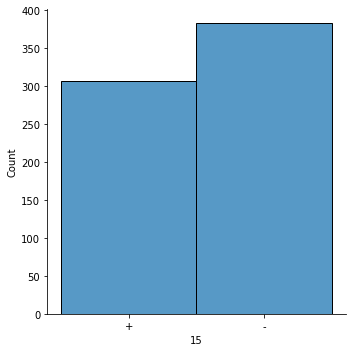

In [4]:
import seaborn as sns

sns.displot(df, x=df[15]);

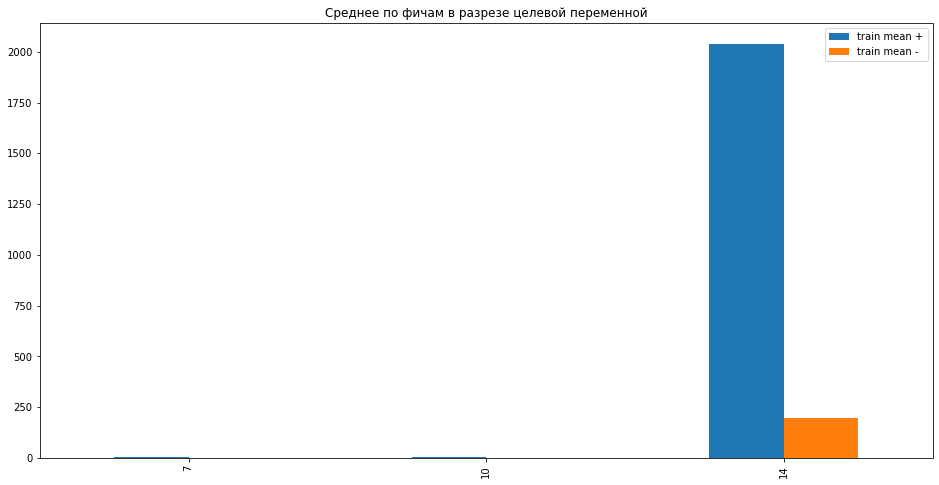

In [5]:
import matplotlib.pyplot as plt

plot_df = pd.DataFrame({
    # среднее по всем фичам трейна за исключением таргета
    'train mean +': df.loc[df[15]=='+', :].describe().iloc[1,1:],
    # среднее по всем фичам теста (здесь таргета нет)
    'train mean -': df.loc[df[15]=='-', :].describe().iloc[1,1:]
})

plot_df.plot.bar(figsize=(16,8))
plt.title('Среднее по фичам в разрезе целевой переменной');

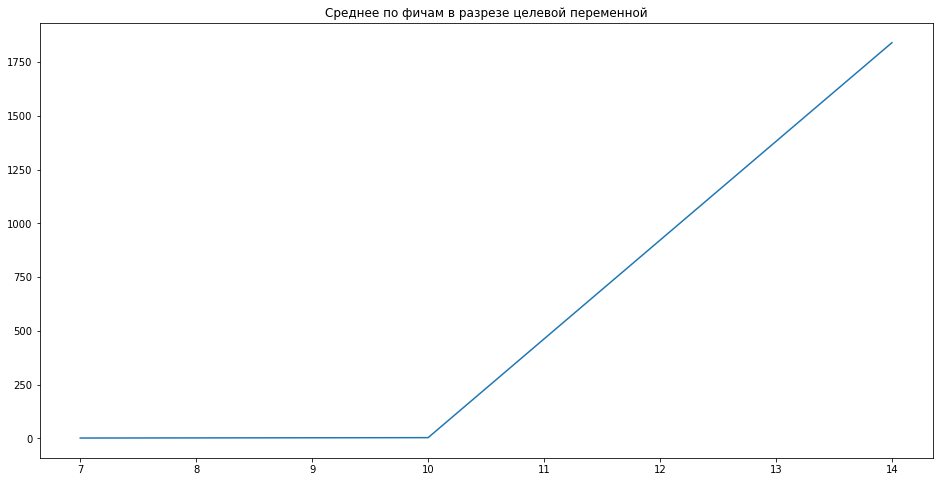

In [6]:
plot_df =  df.loc[df[15]=='+', :].describe().iloc[1,1:] - df.loc[df[15]=='-', :].describe().iloc[1,1:]

plot_df.plot(figsize=(16,8))
plt.title('Среднее по фичам в разрезе целевой переменной');

сделать feature engineering

In [7]:
indices = np.where(df[13] != '?')
col_med = np.median(np.take(df[13], indices[0]).astype(str).astype(int))
df.replace('?', col_med, inplace=True)
df[13] = df[13].map(int)

In [8]:
for t in df.columns:
    cat_num = 1
    if '?' in df[t]:
        indices = np.where(df[t] != '?')
        col_med = np.median(np.take(df[t], indices[0]).astype(str).astype(float))
        df.replace('?', col_med, inplace=True)
        df[t] = df[t].map(float)
    if df[t].dtype==object:
        for cat in df[t].unique():
            df[t].replace(cat, cat_num, inplace=True)
            cat_num += 1
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    float64
 1   1       690 non-null    int64  
 2   2       690 non-null    float64
 3   3       690 non-null    int64  
 4   4       690 non-null    int64  
 5   5       690 non-null    float64
 6   6       690 non-null    int64  
 7   7       690 non-null    float64
 8   8       690 non-null    int64  
 9   9       690 non-null    int64  
 10  10      690 non-null    int64  
 11  11      690 non-null    int64  
 12  12      690 non-null    int64  
 13  13      690 non-null    int64  
 14  14      690 non-null    int64  
 15  15      690 non-null    int64  
dtypes: float64(4), int64(12)
memory usage: 86.4 KB


In [9]:
df[15].value_counts()

2    383
1    307
Name: 15, dtype: int64

In [10]:
df[15].replace(2, 0, inplace=True)

обучить любой классификатор (какой вам нравится)

In [11]:
%%time
from sklearn.ensemble import RandomForestRegressor

parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 8}

forest = RandomForestRegressor(**parameters)
forest.fit(df.drop([15], axis=1), df[15])

CPU times: user 530 ms, sys: 48.1 ms, total: 578 ms
Wall time: 561 ms


RandomForestRegressor(max_depth=6, n_estimators=25, n_jobs=8, random_state=27)

разобраться с SHAP и построить важности признаков для

Text(0.5, 1.0, 'Топ 10 важных признаков')

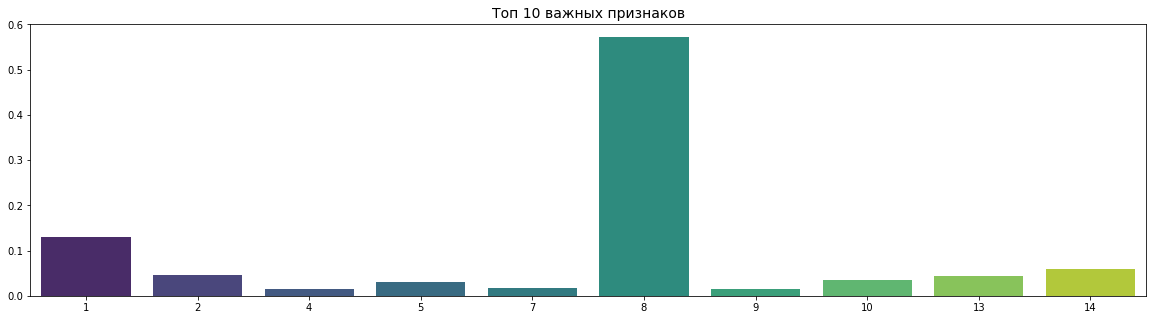

In [12]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = df.drop([15], axis=1).columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("Топ 10 важных признаков", size=14)

In [13]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

x_data = df.drop([15], axis=1)
y_data = df[15]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7)
model = xgb.XGBClassifier()

model.fit(x_train, y_train)
y_predict = model.predict(x_test)

/home/mrp/anaconda3/envs/ml_business/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:16:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [14]:
from sklearn.metrics import (mean_absolute_error, r2_score, recall_score, precision_score, 
                            roc_auc_score, accuracy_score, f1_score)

def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 
    return f1, roc, rec, prc

evaluate_results(y_test, y_predict)

Classification results:
f1: 89.47%
roc: 91.03%
recall: 89.47%
precision: 89.47%


(0.8947368421052632,
 0.9103313840155947,
 0.8947368421052632,
 0.8947368421052632)

In [15]:
import shap
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


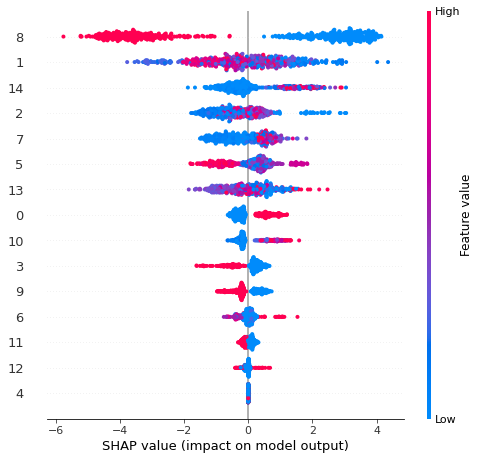

In [16]:
# summarize the effects of all the features
shap.summary_plot(shap_values, x_train, max_display=20)

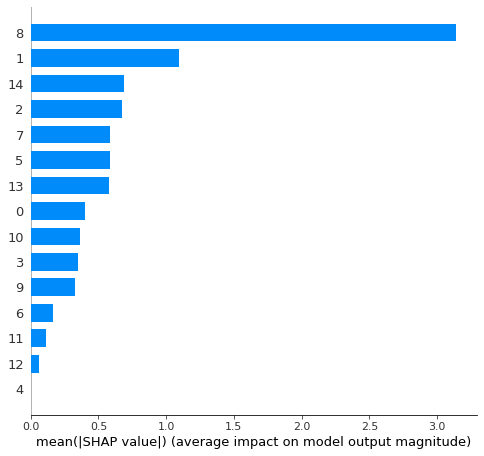

In [17]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

In [18]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[8,:], x_train.iloc[8,:])

In [19]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[1,:], x_train.iloc[1,:])

In [20]:
shap.force_plot(explainer.expected_value, shap_values[14,:], x_train.iloc[14,:])